In [400]:

import pandas as pd
from pathlib import Path
import glob
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

In [401]:
files_path = glob.glob('./coins/ETH/*.csv')
eth_dfs = []
for file_path in files_path:
    eth_df = pd.read_csv(file_path)
    eth_dfs.append(eth_df)
eth = pd.concat(eth_dfs)
eth['Date'] = pd.to_datetime(eth['timestamp']).dt.date
eth = eth.drop(columns=['timestamp'])
eth.index = pd.DatetimeIndex(eth['Date'])
eth.index.freq = pd.infer_freq(eth.index)
eth.sort_index(ascending=False, inplace=True)
eth = eth.drop(columns=['Date'])
eth.head()



,open,high,low,close,volume,marketCap
Date,,,,,,
2023-05-21,1820.138100,1827.922002,1799.946875,1804.531380,3.386769e+09,2.170329e+11
2023-05-20,1812.766060,1829.009603,1808.046731,1820.478001,2.951656e+09,2.189539e+11
2023-05-19,1800.994364,1826.194197,1797.434451,1812.589510,4.796110e+09,2.180104e+11
2023-05-18,1822.068213,1831.450317,1774.195012,1801.728481,5.673124e+09,2.167107e+11
2023-05-17,1824.068405,1835.554602,1786.671999,1821.859581,6.352162e+09,2.191387e+11


In [402]:
eth.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1372 entries, 2023-05-21 to 2020-01-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1372 non-null   float64
 1   high       1372 non-null   float64
 2   low        1372 non-null   float64
 3   close      1372 non-null   float64
 4   volume     1372 non-null   float64
 5   marketCap  1372 non-null   float64
dtypes: float64(6)
memory usage: 75.0 KB


## First: Decompose Time Series Components to Trend, Seasonality, & Noise

<Axes: title={'center': 'Ether'}, xlabel='Date'>

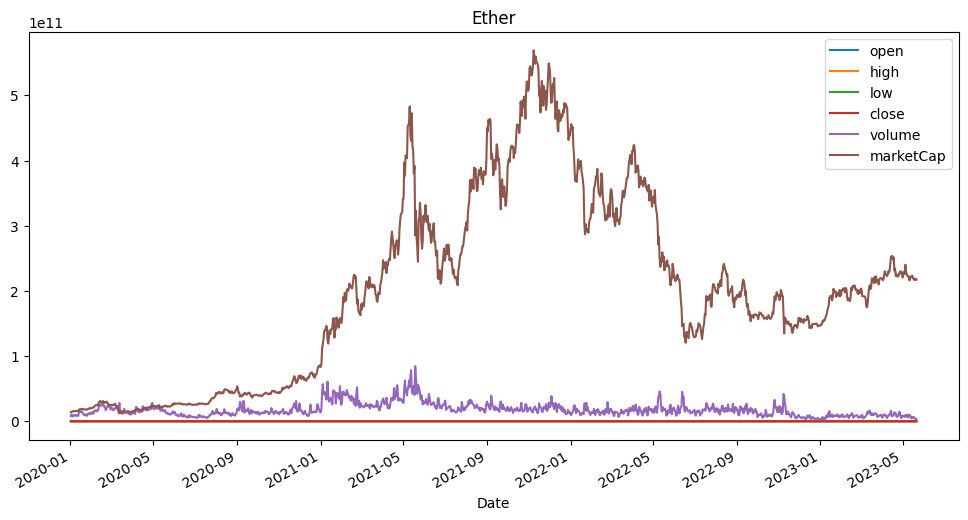

In [403]:
eth.plot(title='Ether',figsize=(12,6))

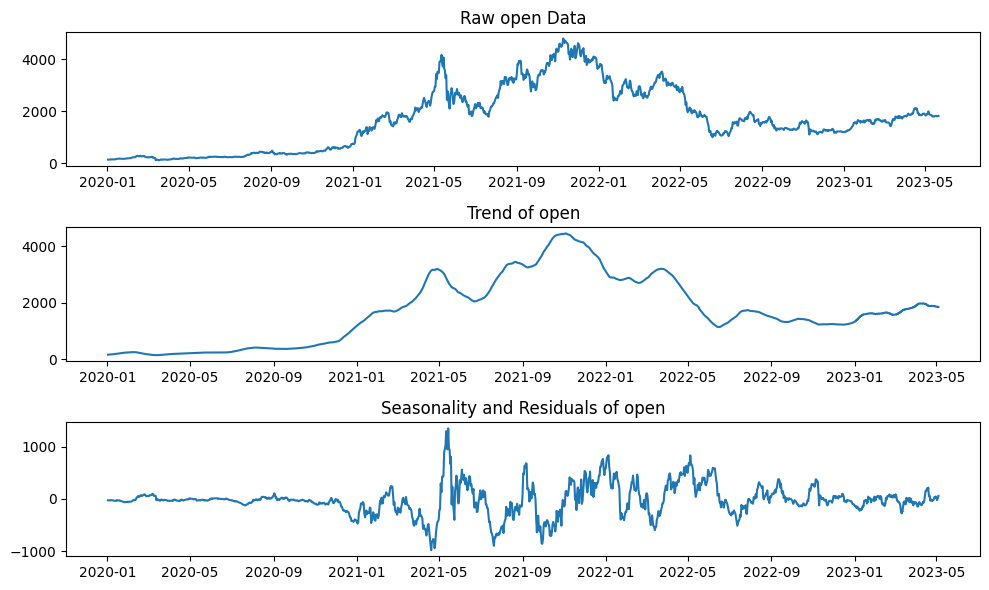

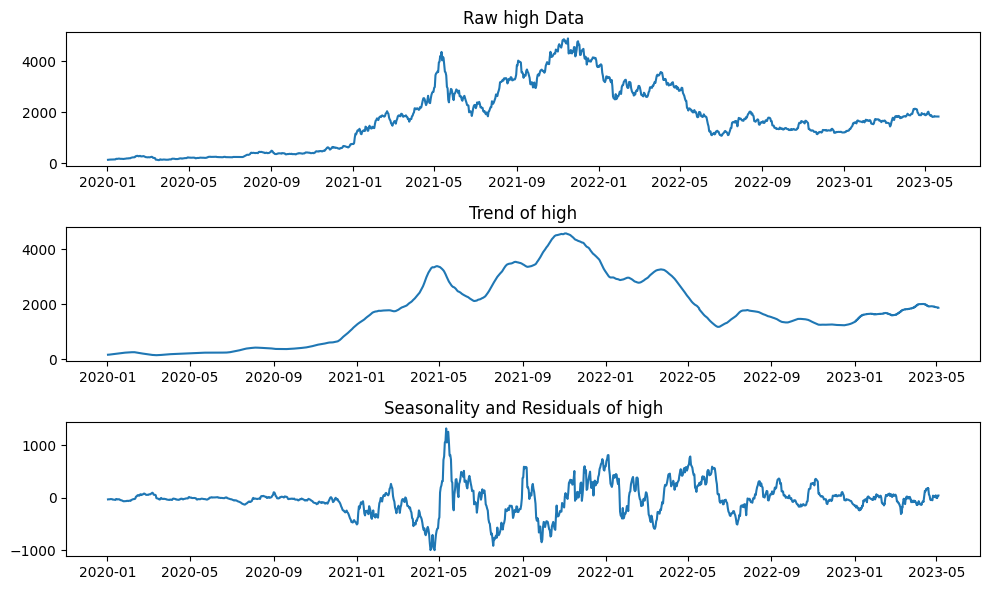

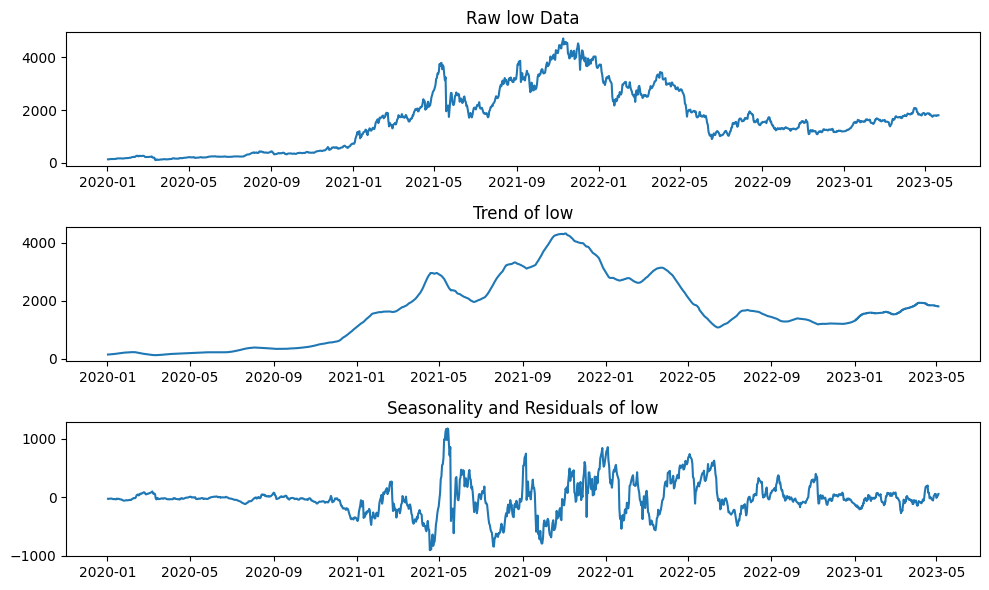

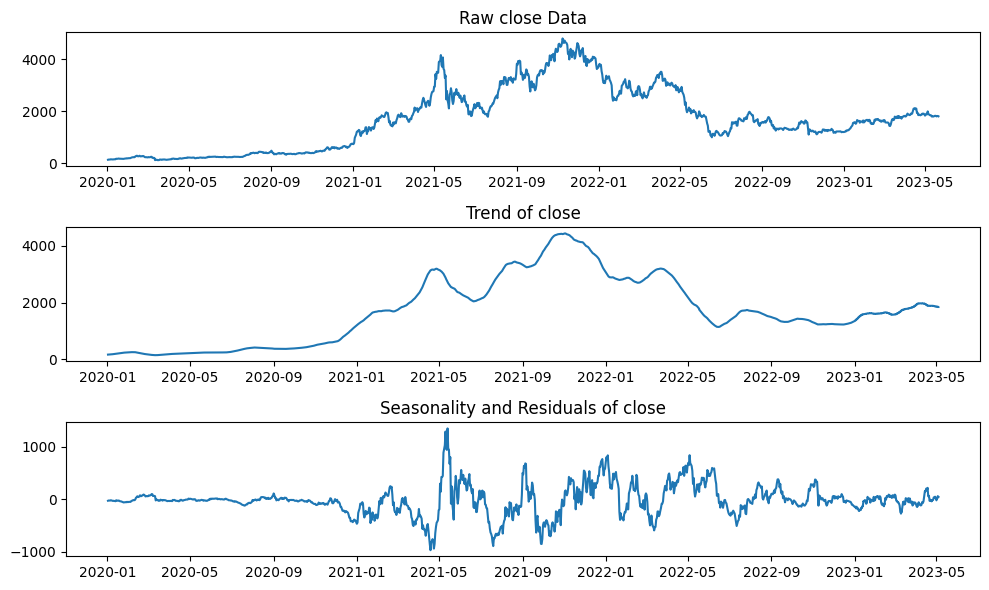

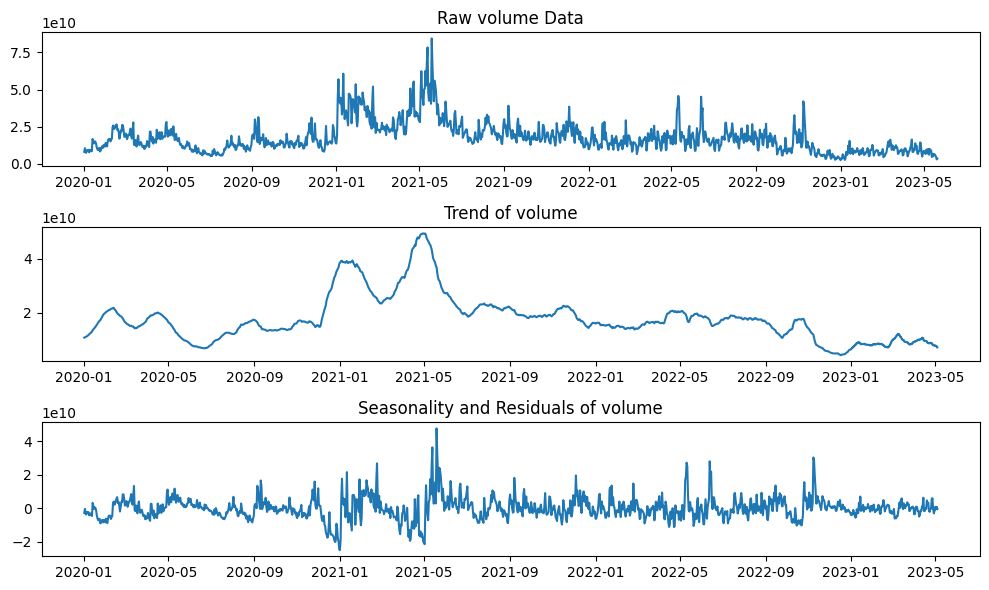

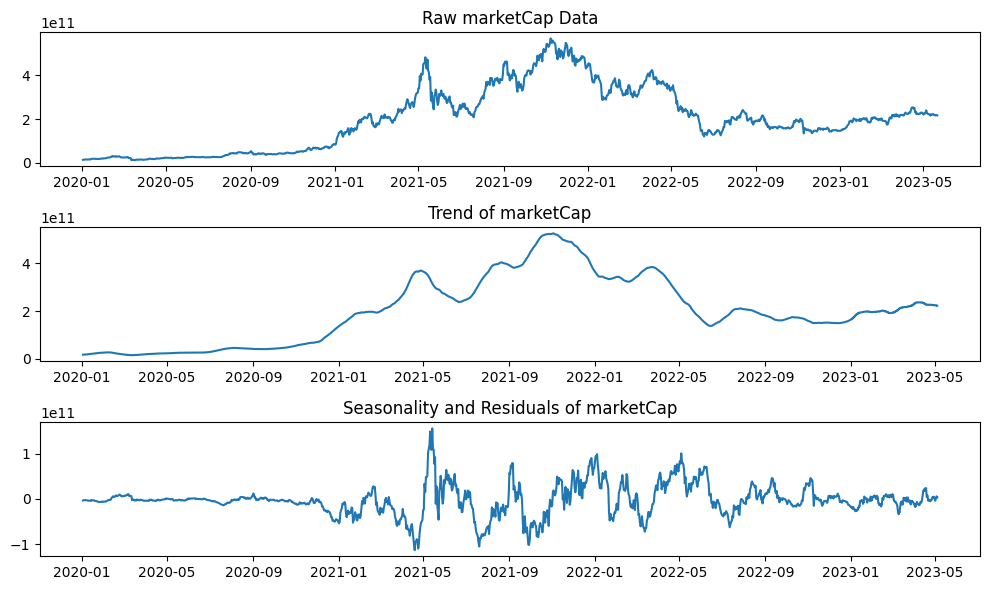

In [404]:
import matplotlib.pyplot as plt
# Define the parameters to decompose
parameters = ['open', 'high', 'low', 'close', 'volume', 'marketCap']

# Perform time series decomposition for each parameter
for parameter in parameters:
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(eth[parameter])
    plt.title(f"Raw {parameter} Data")
    
    plt.subplot(3, 1, 2)
    plt.plot(eth[parameter].rolling(window=30).mean())
    plt.title(f"Trend of {parameter}")
    
    plt.subplot(3, 1, 3)
    plt.plot(eth[parameter] - eth[parameter].rolling(window=30).mean())
    plt.title(f"Seasonality and Residuals of {parameter}")
    
    plt.tight_layout()
    plt.show()

### Second: Check Autocorrelation & Partial Autocorrelation of different Prices

2-1: Open Prices ACF & PACF

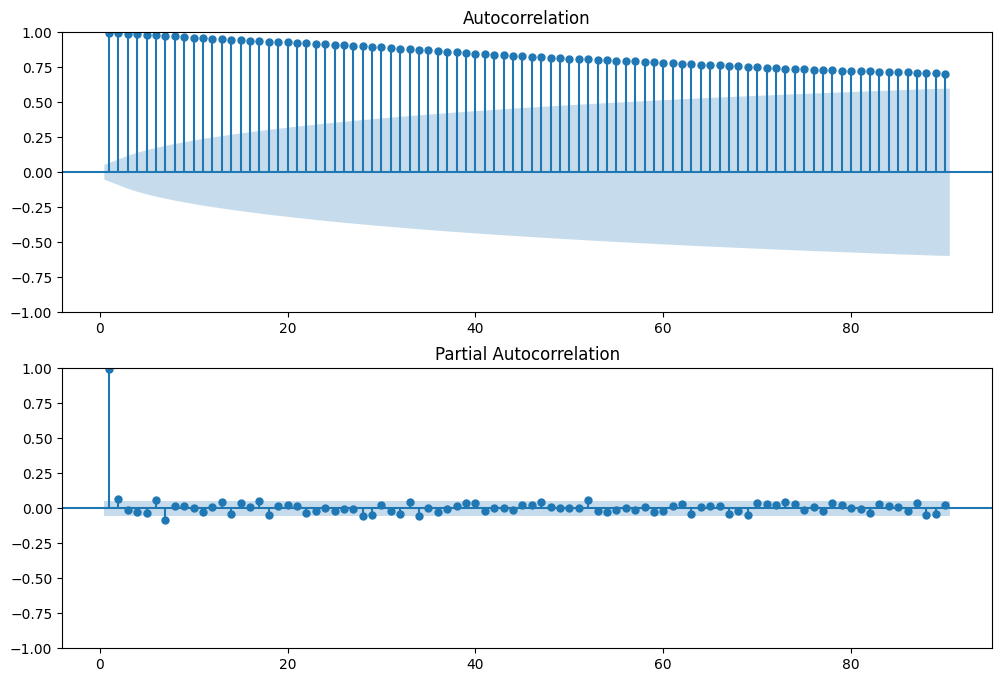

In [405]:
# Plot ACF / PCAF of `open` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.open.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.open.squeeze(), lags=90, ax=ax2, zero=False)

2-2: Close Prices ACF & PACF

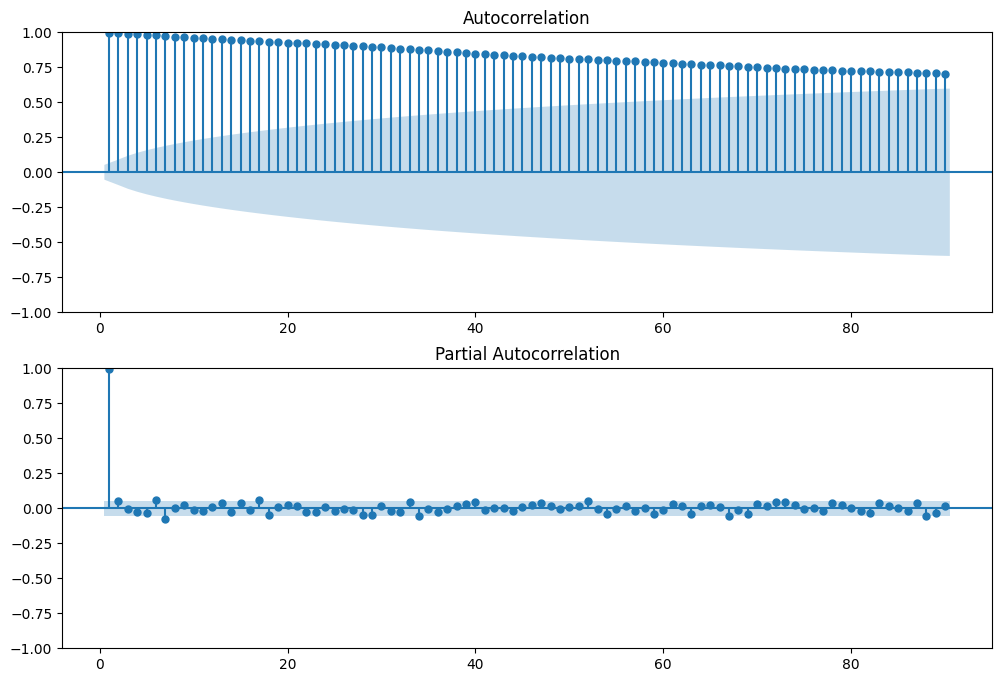

In [406]:
# Plot ACF / PCAF of `close` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.close.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.close.squeeze(), lags=90, ax=ax2, zero=False)

2-3: High Prices Autocorrelation

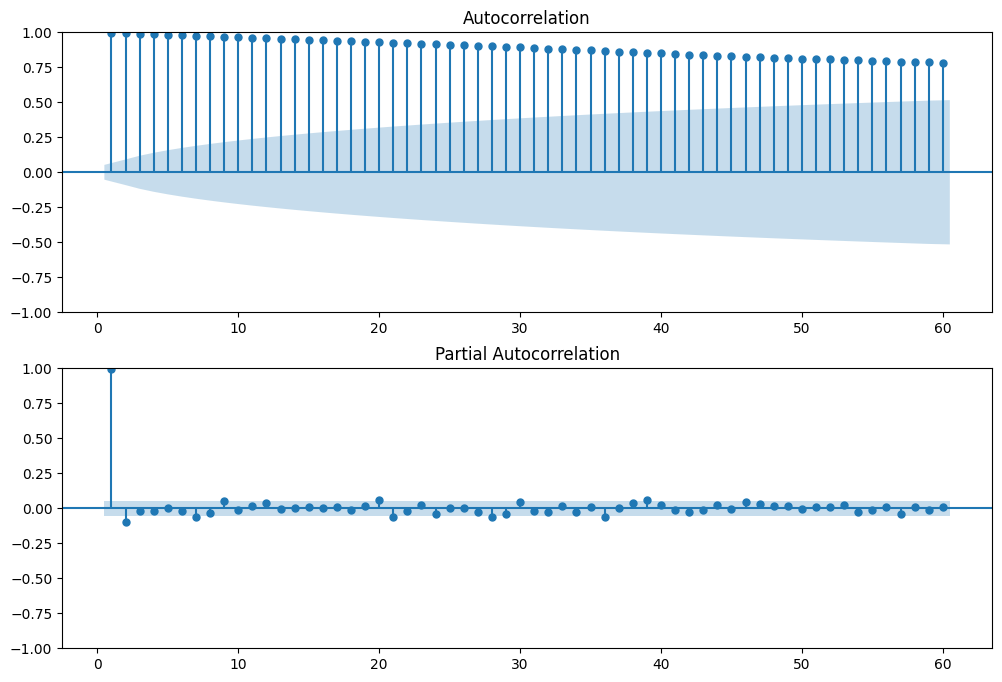

In [407]:
# Plot ACF / PCAF of `high` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.high.squeeze(), lags=60, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.high.squeeze(), lags=60, ax=ax2, zero=False)

2-4: Low Prices Autocorrelation

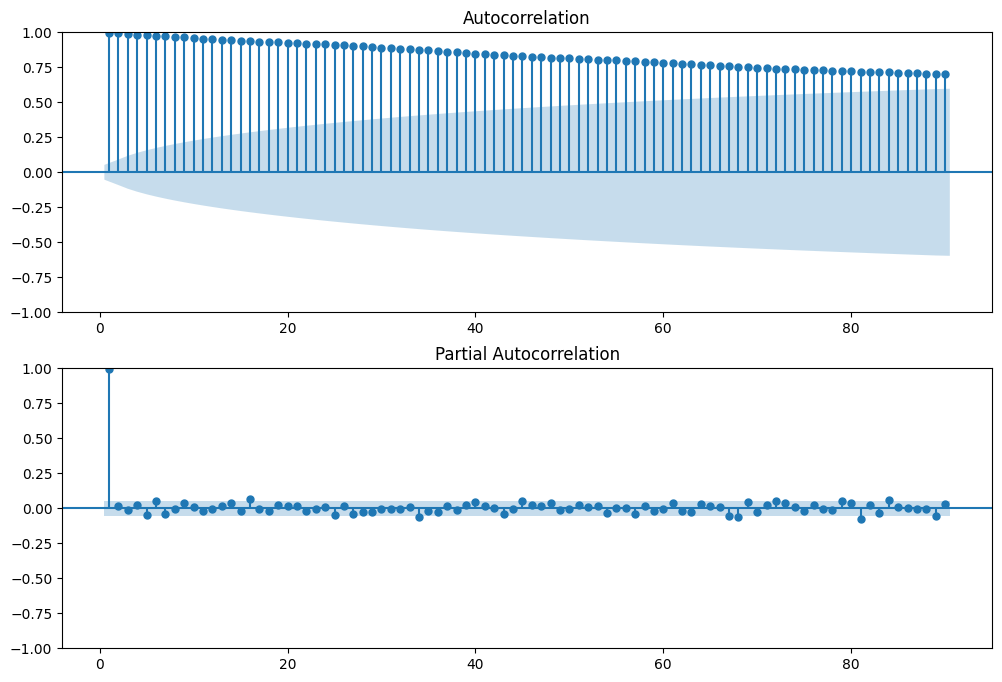

In [408]:
# Plot ACF/PCAF of `low` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.low.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.low.squeeze(), lags=90, ax=ax2, zero=False)

    Observation:
        it appears that there is strong autocorrelation in the ACF up to lag 10, suggesting a non-seasonal AR component. 
        The lack of significant correlation in the PACF beyond the first lag indicates that an MA component may not be necessary.

### Third: Check if Data is Stationary using Augmented Dickey-Fuller 

In [409]:
# Apply Augmented Dickey-Fuller test to check stationary
adfuller(eth.close)

(-1.2177383298330557,
 0.6659189648651412,
 6,
 1365,
 {'1%': -3.4351497363134746,
  '5%': -2.863659724044779,
  '10%': -2.567898540568101},
 15994.99581542682)

    Observation:
        with p-value of 0.4 it indicates that data are non-stationary

In [410]:
adfuller(eth.open)

(-1.0447234076676226,
 0.7366051588332251,
 17,
 1354,
 {'1%': -3.4351888040389302,
  '5%': -2.8636769637158244,
  '10%': -2.5679077212657284},
 16015.416826498524)

    Observation:
        with p-value of 0.7 it indicates that data are non-stationary

In [411]:
adfuller(eth.high)

(-1.0917253532195104,
 0.7183604326047094,
 23,
 1348,
 {'1%': -3.435210382964628,
  '5%': -2.8636864858936333,
  '10%': -2.5679127921571907},
 15445.748078884037)

    Observation:
        with p-value of 0.7 it indicates that data are non-stationar

In [412]:
adfuller(eth.low)

(-1.2492222241187576,
 0.6520715351678035,
 6,
 1365,
 {'1%': -3.4351497363134746,
  '5%': -2.863659724044779,
  '10%': -2.567898540568101},
 16046.988133612624)

    Observation:
        with p-value of 0.7 it indicates that data are non-stationary

### Fourth: Convert Non Stationary Data to Stationary 

<Axes: title={'center': 'CLOSE PRICES'}, xlabel='Date'>

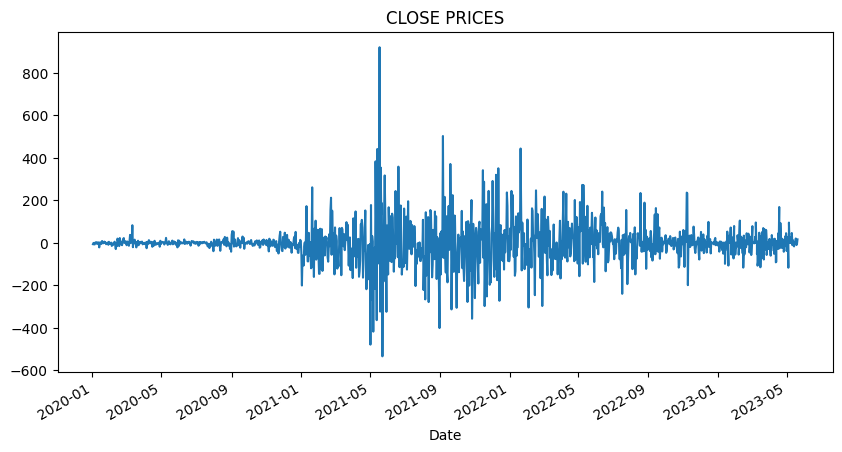

In [413]:
# convert to stationary using diff() function to subtract the trend
close_stationary = eth.close.diff().dropna()
close_stationary.plot(title='CLOSE PRICES',figsize=(10, 5))


<Axes: title={'center': 'OPEN PRICES'}, xlabel='Date'>

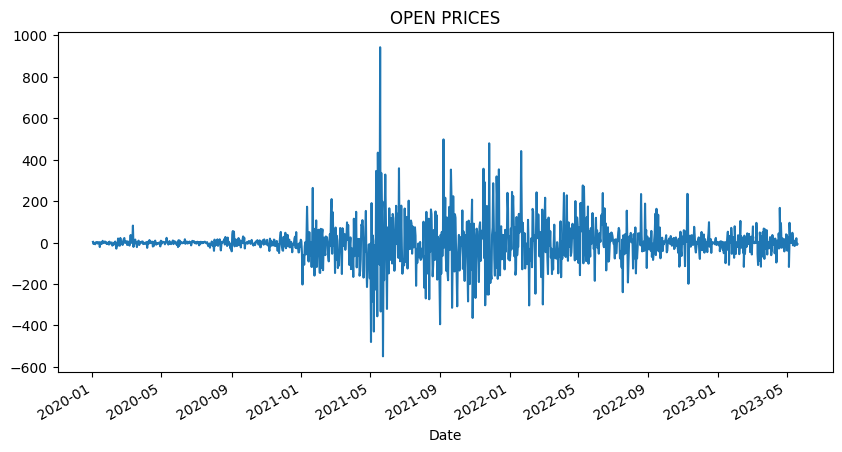

In [414]:
# convert to stationary using diff() function to subtract the trend
open_stationary = eth.open.diff().dropna()
open_stationary.plot(title='OPEN PRICES',figsize=(10, 5))

<Axes: title={'center': 'HIGH PRICES'}, xlabel='Date'>

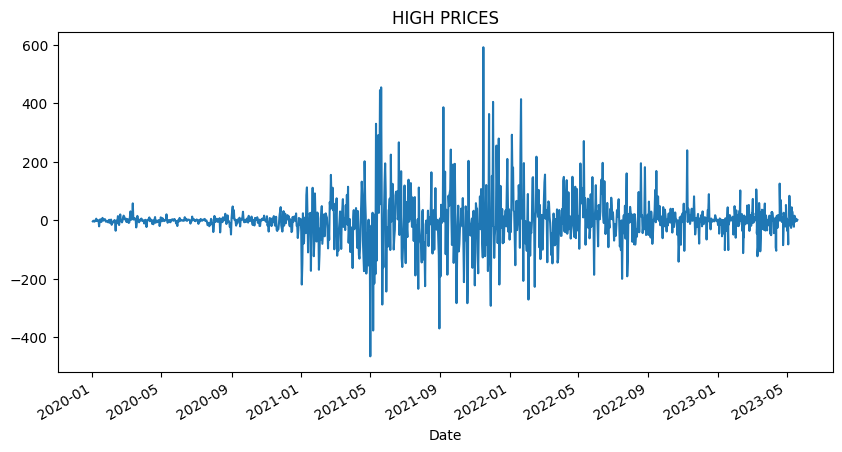

In [415]:
# convert to stationary using diff() function to subtract the trend
high_stationary = eth.high.diff().dropna()
high_stationary.plot(title='HIGH PRICES',figsize=(10, 5))